## EXPLORATORY PART II 

### GRAPH EMBEDDINGS

### 1. Read graph, display degree distribution and perform normality test

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

c:\MSc DTU\Semester 1\00. Introduction to BA\Assignment\city-bike\CityBikesVenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = "../data/"

In [3]:
trips_clean_path = os.path.join(data_path, "Trips_2018_clean.csv")

data = pd.read_csv(trips_clean_path)
data.head()

,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age
0,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26
1,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49
2,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62
3,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44
4,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26


Load the graphs

In [4]:
# --- Step 1: Load the graphs ---
#G = nx.read_gexf('monthly_graphs/graph_2018_month01.gexf')
G = nx.read_gexf('2018_graph/graph_2018.gexf')

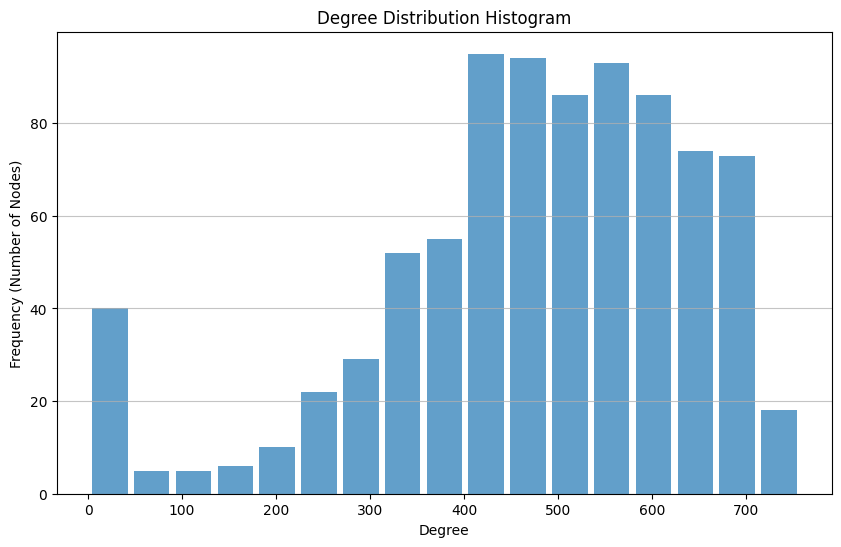

In [5]:
# --- Step 2: Calculate Node Degrees ---
degrees = [G.degree(n) for n in G.nodes()]

# --- Step 3: Plot the Histogram ---
plt.figure(figsize=(10, 6))

plt.hist(degrees, bins='auto', alpha=0.7, rwidth=0.85)

plt.title("Degree Distribution Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency (Number of Nodes)")
plt.grid(axis='y', alpha=0.75)
plt.show()

Shapiro-Wilk Test Statistic: 0.9301548050279149
P-value: 2.2102822857468086e-19
The data does not appear to be normally distributed (reject H0).


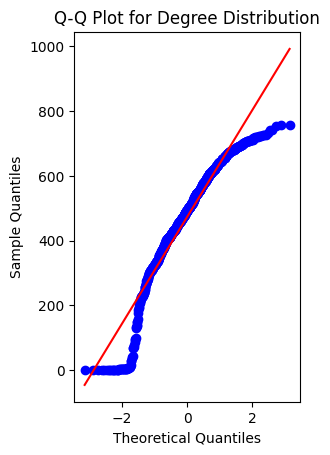

In [6]:
# --- Step 3: Perform Normality Testing and Plot ---
# Perform the Shapiro-Wilk test for normality on the degrees
if len(degrees) > 2:
    shapiro_statistic, shapiro_p_value = stats.shapiro(degrees)
    print(f"Shapiro-Wilk Test Statistic: {shapiro_statistic}")
    print(f"P-value: {shapiro_p_value}")
    if shapiro_p_value > 0.05:
        print("The data appears to be normally distributed (fail to reject H0).")
    else:
        print("The data does not appear to be normally distributed (reject H0).")
else:
    print("Not enough data points to perform Shapiro-Wilk test.")


# Generate and display the Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(degrees, dist="norm", plot=plt)
plt.title("Q-Q Plot for Degree Distribution")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")

# Show the plots
plt.show()

### 2. Create vector representation of node using node2vec

In [47]:
# --- Step 1: Generate Embeddings with Node2Vec ---

# The Node2Vec constructor takes the graph, dimensions of the embeddings,
# and parameters for the random walks.
# q: choose value q<1 to prioritise DFS bias 
# walk_length: How many nodes are in each random walk.
# num_walks: How many random walks to start from each node.
# workers: Number of parallel threads to use.
#node2vec = Node2Vec(G, q=0.5,dimensions=64, walk_length=30, num_walks=200, workers=4)
node2vec = Node2Vec(G, q=0.5, dimensions=64, walk_length=80, num_walks=50, workers=4)

# Fit the model to generate the embeddings.
# This may take a few minutes depending on the size of your graph.
# 'window' is the context size for the underlying Word2Vec model.
# 'min_count=1' ensures all nodes are embedded.
model = node2vec.fit(window=10, min_count=1, batch_words=4)
print("Node2Vec model training complete.")

# The embeddings are stored in a KeyedVectors object (part of gensim)
# We can access the vector for a specific node like this:
# vector_for_node_A = model.wv['station_id_A']

# Get all node names (station IDs) and their corresponding vectors
nodes = list(G.nodes())
embedding_vectors = [model.wv[node] for node in nodes]


Computing transition probabilities: 100%|██████████| 843/843 [15:34<00:00,  1.11s/it]


Node2Vec model training complete.


### 2.1 K-means clustering using embedding vectors 

Elbow method for k-means

Calculating inertia for k values from 3 to 40...


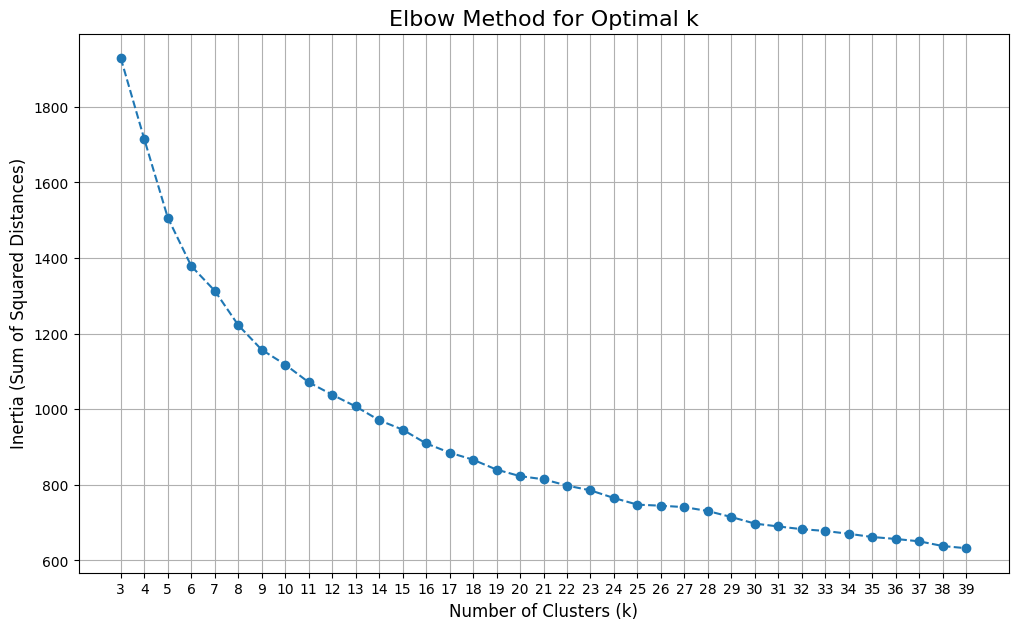

In [ ]:
# --- Step 1: Run K-Means for a Range of k Values ---

k_range = np.arange(3,40,1)
inertias = []

print("Calculating inertia for k values from 3 to 40...")

for k in k_range:
    # Initialize and fit the K-Means model for the current k
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=10)
    kmeans.fit(embedding_vectors)
    
    # Append the inertia (sum of squared distances) to our list
    inertias.append(kmeans.inertia_)
    #print(f"  k={k}, Inertia={kmeans.inertia_:.2f}")


# --- Step 2: Plot the Elbow Curve ---

plt.figure(figsize=(12, 7))
plt.plot(k_range, inertias, marker='o', linestyle='--')

plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

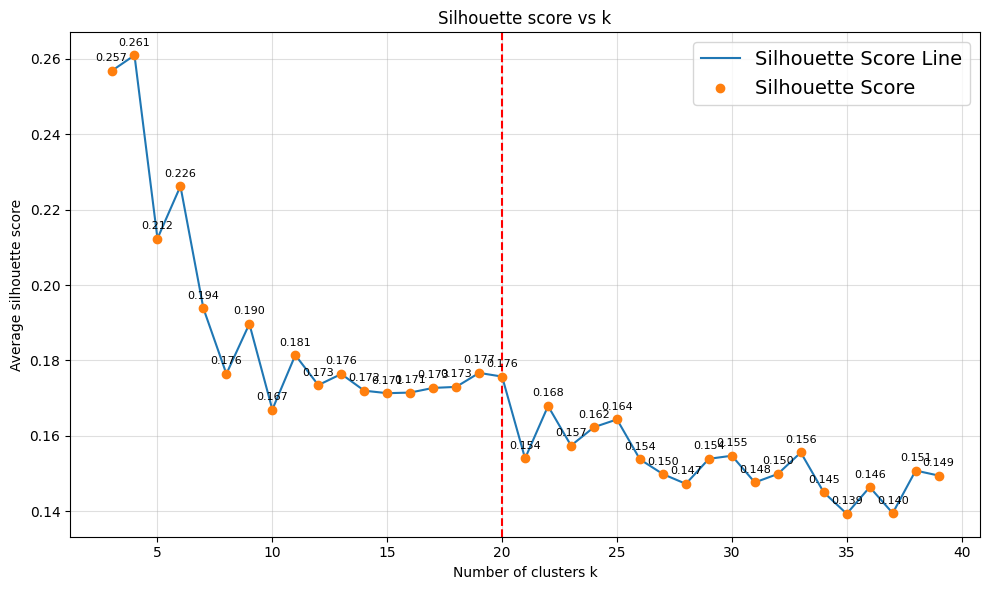

In [232]:
# overall silhouette score
k_values = np.arange(3,40,1)
sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=10)
    clusters = kmeans.fit_predict(embedding_vectors)
    score = silhouette_score(embedding_vectors, clusters, metric='euclidean')
    sil_scores.append(score)

plt.figure(figsize=(10,6))

#line in one color, markers in another
plt.plot(k_values, sil_scores, color='tab:blue',label='Silhouette Score Line')             # line
plt.scatter(k_values, sil_scores, color='tab:orange', zorder=3, label='Silhouette Score')  # points
plt.axvline(x=20, color='red', linestyle='--', linewidth=1.5)  # vertical line at k=20

# add value labels above each point
for k, s in zip(k_values, sil_scores):
    plt.text(k, s + 0.002, f"{s:.3f}", ha='center', va='bottom', fontsize=8)

plt.xlabel("Number of clusters k")
plt.ylabel("Average silhouette score")
plt.title("Silhouette score vs k")
plt.legend(fontsize=14)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

In [233]:
stations = pd.read_csv('Station_Coordinates.csv')
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843 entries, 0 to 842
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  843 non-null    float64
 1   latitude    843 non-null    float64
 2   longitude   843 non-null    float64
dtypes: float64(3)
memory usage: 19.9 KB


In [360]:
k_values = [14,15,16,17,18]


for i,k in enumerate(k_values):
    #Fit k-means
    kmeans = KMeans(n_clusters=k,random_state=42,init='k-means++',n_init=10)
    clusters = kmeans.fit_predict(embedding_vectors)

    # Add cluster assignment as a new column for each k
    stations[f'cluster_{k}'] = clusters


In [ ]:
# We decide that k=16 clusters
# Create a dictionary for fast lookup: station_id -> cluster_16
cluster_map = stations.set_index('station_id')['cluster_16']

# Add new columns to dataframe with start and end stations' cluster index
data['start_cluster_16'] = data['start_station_id'].map(cluster_map)
data['end_cluster_16'] = data['end_station_id'].map(cluster_map).astype("Int32")

print(data[['start_cluster_16','end_cluster_16']])

          start_cluster_16  end_cluster_16
0                       13               2
1                       13               7
2                       13               7
3                       13               4
4                       13               3
...                    ...             ...
17480671                 5              12
17480672                 5              12
17480674                 3              12
17480675                 8               3
17480677                 0               0

[17480675 rows x 2 columns]


Clustering complete.


C:\Users\billy\AppData\Local\Temp\ipykernel_15572\3741767804.py:20: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 16
  plt.legend(handles=scatter.legend_elements()[0], labels=range(num_clusters))


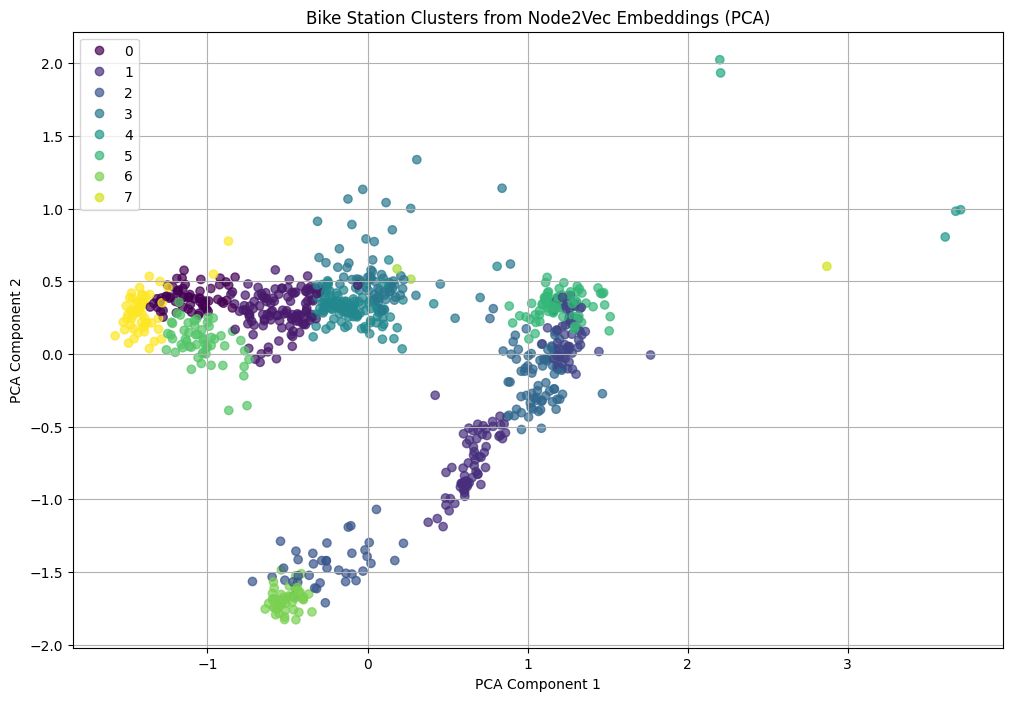


--- Analysis of Station Clusters ---

Cluster 0 contains 64 stations.
Sample stations: ['2006.0', '3282.0', '3165.0', '281.0', '3137.0']

Cluster 1 contains 113 stations.
Sample stations: ['492.0', '519.0', '435.0', '509.0', '494.0']

Cluster 2 contains 64 stations.
Sample stations: ['460.0', '3093.0', '3086.0', '3430.0', '2002.0']

Cluster 3 contains 60 stations.
Sample stations: ['3354.0', '3418.0', '3349.0', '3423.0', '3365.0']

Cluster 4 contains 39 stations.
Sample stations: ['3118.0', '3119.0', '3124.0', '3125.0', '3615.0']

Cluster 5 contains 79 stations.
Sample stations: ['239.0', '270.0', '366.0', '258.0', '324.0']

Cluster 6 contains 70 stations.
Sample stations: ['363.0', '3002.0', '426.0', '3256.0', '2008.0']

Cluster 7 contains 111 stations.
Sample stations: ['432.0', '3263.0', '293.0', '445.0', '317.0']

Cluster 8 contains 3 stations.
Sample stations: ['3254.0', '3479.0', '3182.0']

Cluster 9 contains 2 stations.
Sample stations: ['3239.0', '3036.0']

Cluster 10 contains

In [362]:
# --- Step 3: Analyze the Embeddings with Clustering ---

# 1. Cluster the embeddings using K-Means to find groups of similar stations
num_clusters = 16
kmeans = KMeans(n_clusters=num_clusters, random_state=42, init='k-means++', n_init=10)
clusters = kmeans.fit_predict(embedding_vectors)

print("Clustering complete.")

# 2. Use PCA to reduce the embedding dimensions for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embedding_vectors)

# 3. Visualize the clustered embeddings
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title('Bike Station Clusters from Node2Vec Embeddings (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=range(num_clusters))
plt.grid(True)
plt.show()


# --- Step 4: Inspect the Clusters ---
results = pd.DataFrame({'station_id': nodes, 'cluster': clusters})

print("\n--- Analysis of Station Clusters ---")
for i in range(num_clusters):
    cluster_nodes = results[results['cluster'] == i]['station_id'].tolist()
    print(f"\nCluster {i} contains {len(cluster_nodes)} stations.")
    print(f"Sample stations: {cluster_nodes[:5]}")


## 4. Determine central nodes for each cluster

Calculate traditional centrality scores and find highest average scores

In [363]:
# --- Step 1: Calculate Centrality Scores for Every Node ---

# Degree Centrality: Measures the number of connections a node has.
degree_centrality = nx.degree_centrality(G)

# Betweenness Centrality: Measures how often a node lies on the shortest path between other nodes.
# This is a great indicator of a "bridge" node. It's computationally intensive.
betweenness_centrality = nx.betweenness_centrality(G)

print("Calculated degree and betweenness centrality.")

# --- Step 2: Add these scores to your results DataFrame ---

# The centrality functions return dictionaries. We'll map them to our DataFrame.
results['degree_centrality'] = results['station_id'].map(degree_centrality)
results['betweenness_centrality'] = results['station_id'].map(betweenness_centrality)


# --- Step 3: Find the Most Central *Cluster* ---

# Now, we group by cluster and find the average centrality for each group.
cluster_analysis = results.groupby('cluster').agg({
    'degree_centrality': 'mean',
    'betweenness_centrality': 'mean',
    'station_id': 'count'  # See how many stations are in each cluster
}).rename(columns={'station_id': 'station_count'})

# Sort the clusters by their average centrality to find the most important ones.
# A high betweenness centrality is a strong sign of a central "bridge" cluster.
sorted_clusters = cluster_analysis.sort_values(by='betweenness_centrality', ascending=False)

print("\n--- Centrality Analysis by Cluster ---")
print(sorted_clusters)



Calculated degree and betweenness centrality.

--- Centrality Analysis by Cluster ---
         degree_centrality  betweenness_centrality  station_count
cluster                                                          
13                0.010689                0.001185              2
7                 0.718495                0.000977            111
1                 0.699756                0.000936            113
6                 0.515575                0.000884             70
2                 0.638844                0.000555             64
4                 0.455539                0.000449             39
11                0.602583                0.000439             56
5                 0.561562                0.000317             79
10                0.509244                0.000290             74
0                 0.551440                0.000289             64
3                 0.501880                0.000249             60
12                0.342371                0.000182      

In [369]:
# --- Step 4: Identify the Central Nodes ---

# The cluster at the top of the sorted list is your most central cluster.
# The nodes within that cluster are your central nodes.
central_cluster_id = sorted_clusters.index[0]
central_nodes = results[results['cluster'] == central_cluster_id]

print(f"\nCluster {central_cluster_id} is the most central.")
print("It contains nodes with the highest average betweenness centrality.")
print("\nTop 5 central stations in this cluster (by degree centrality):")
print(central_nodes.sort_values(by='degree_centrality', ascending=False).head())


Cluster 13 is the most central.
It contains nodes with the highest average betweenness centrality.

Top 5 central stations in this cluster (by degree centrality):
     station_id  cluster  degree_centrality  betweenness_centrality
813      3040.0       13           0.017815                 0.00237
823      3672.0       13           0.003563                 0.00000


In [370]:
# --- Find the Most Central Node in Each Cluster ---

# The .loc and .idxmax() methods are perfect for this.
# .idxmax() finds the index of the first occurrence of the maximum value.
# We then use .loc to select that entire row.
most_central_nodes = results.loc[results.groupby('cluster')['betweenness_centrality'].idxmax()]

print("\\n--- Most Central Node in Each Cluster (based on Betweenness Centrality) ---")
print(most_central_nodes)

# If you prefer to find the most connected node (highest degree) instead:
most_connected_nodes = results.loc[results.groupby('cluster')['degree_centrality'].idxmax()]

print("\n\n--- Most Connected Node in Each Cluster (based on Degree Centrality) ---")
print(most_connected_nodes)

\n--- Most Central Node in Each Cluster (based on Betweenness Centrality) ---
     station_id  cluster  degree_centrality  betweenness_centrality
4        2006.0        0           0.723278                0.001109
122       448.0        1           0.678147                0.003605
390       532.0        2           0.836105                0.001549
475      3599.0        3           0.547506                0.000659
412      3129.0        4           0.824228                0.003751
187       392.0        5           0.763658                0.000946
49        327.0        6           0.745843                0.008507
62        358.0        7           0.804038                0.005296
47       3254.0        8           0.085511                0.000011
789      3239.0        9           0.002375                0.000000
712      3432.0       10           0.187648                0.002516
382       441.0       11           0.817102                0.001302
439      3555.0       12           0.5

## 5. Maps Visualisation

In [366]:
# Convert 'station_id' to float
results['station_id'] = results['station_id'].astype(float)

station_coords_data = pd.read_csv('Station_Coordinates.csv')
df_coords = pd.DataFrame(station_coords_data)

In [367]:
# Ensure the 'station_id' columns have a consistent data type
most_central_nodes['station_id'] = pd.to_numeric(most_central_nodes['station_id'], errors='coerce')
df_coords['station_id'] = pd.to_numeric(df_coords['station_id'], errors='coerce')

# Merge to get the coordinates for our central nodes
central_nodes_map_df = pd.merge(
    most_central_nodes, 
    df_coords, 
    on='station_id', 
    how='left'
)

# Clean any potential merge failures
central_nodes_map_df.dropna(subset=['latitude', 'longitude'], inplace=True)


# --- Step 2: Initialize the Map and Define Colors ---
if central_nodes_map_df.empty:
    print("Error: No central nodes with valid coordinates to plot.")
else:
    map_center = [central_nodes_map_df['latitude'].mean(), central_nodes_map_df['longitude'].mean()]
    station_map = folium.Map(location=map_center, zoom_start=12)
    

    # 2. Get a colormap from matplotlib
    # 'tab10' is great for up to 10 clusters. 'hsv' is good for more.
    colormap = cm.get_cmap('hsv', num_clusters) 
    
    # 3. Create a list of hex color codes
    cluster_colors = [colors.to_hex(colormap(i)) for i in range(num_clusters)]
    
    # --- Step 3: Loop Through and Plot ONLY the Central Nodes ---
    for _, station in central_nodes_map_df.iterrows():
        cluster_index = int(station['cluster'])
        
        # Create an informative popup
        popup_html = f"""
        <b>Central Node for Cluster {cluster_index}</b><br>
        ------------------------------------<br>
        <b>Station ID:</b> {station['station_id']}<br>
        <b>Betweenness:</b> {station['betweenness_centrality']:.4f}<br>
        <b>Degree:</b> {station['degree_centrality']:.4f}
        """
        popup = folium.Popup(popup_html, max_width=300)
        
        # Add a large, color-coded marker with a star icon
        folium.Marker(
            location=[station['latitude'], station['longitude']],
            popup=popup,
            tooltip=f"Central Node (Cluster {cluster_index})",
            icon=folium.Icon(
                color=cluster_colors[cluster_index], 
                icon='star', 
                prefix='fa'
            )
        ).add_to(station_map)


    # --- Step 4: Save the Map ---
    map_filename = 'central_nodes_only_map.html'
    station_map.save(map_filename)

    print(f"Map of central nodes has been saved to '{map_filename}'.")

Map of central nodes has been saved to 'central_nodes_only_map.html'.


C:\Users\billy\AppData\Local\Temp\ipykernel_15572\2638115039.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('hsv', num_clusters)
C:\Users\billy\AppData\Local\Temp\ipykernel_15572\2638115039.py:51: UserWarning: color argument of Icon should be one of: {'pink', 'white', 'lightblue', 'gray', 'red', 'darkpurple', 'purple', 'lightred', 'lightgray', 'orange', 'darkgreen', 'blue', 'green', 'cadetblue', 'beige', 'darkblue', 'lightgreen', 'darkred', 'black'}.
  icon=folium.Icon(


In [368]:
# --- Step 1: Prepare the Full DataFrame with Coordinates ---
df_full = pd.merge(results, df_coords, on='station_id', how='left')
df_full.dropna(subset=['latitude', 'longitude'], inplace=True)


# --- Step 2: Separate the DataFrames for Plotting ---
central_station_ids = most_central_nodes['station_id'].tolist()
central_nodes_df = df_full[df_full['station_id'].isin(central_station_ids)]
regular_nodes_df = df_full[~df_full['station_id'].isin(central_station_ids)]


# --- Step 3: Initialize the Map and DYNAMICALLY Define Colors ---
if df_full.empty:
    print("Error: No data to plot.")
else:
    map_center = [df_full['latitude'].mean(), df_full['longitude'].mean()]
    station_map = folium.Map(location=map_center, zoom_start=12)
    
    # --- NEW: Dynamic Color Generation ---
    # 1. Get the number of unique clusters from your data
    #num_clusters = int(df_full['cluster'].nunique())
    
    # 2. Get a colormap from matplotlib
    # 'tab10' is great for up to 10 clusters. 'hsv' is good for more.
    colormap = cm.get_cmap('hsv', num_clusters) 
    
    # 3. Create a list of hex color codes
    cluster_colors = [colors.to_hex(colormap(i)) for i in range(num_clusters)]
    
    print(f"Generated {num_clusters} distinct colors for the clusters.")
    

    # --- Step 4: Add the "Base Layer" of Regular Stations ---
    # (This loop now works for any number of clusters)
    for _, station in regular_nodes_df.iterrows():
        cluster_index = int(station['cluster'])
        folium.CircleMarker(
            location=[station['latitude'], station['longitude']],
            radius=5,
            color=cluster_colors[cluster_index],
            fill=True,
            fill_color=cluster_colors[cluster_index],
            fill_opacity=0.5,
            popup=f"<b>Station:</b> {station['station_id']}<br><b>Cluster:</b> {cluster_index}"
        ).add_to(station_map)

    # --- Step 5: Add the "Top Layer" of Central Stations ---
    # (This loop also works for any number of clusters)
    for _, station in central_nodes_df.iterrows():
        cluster_index = int(station['cluster'])
        popup_html = f"""
        <b>Central Node for Cluster {cluster_index}</b><br>
        ------------------------------------<br>
        <b>Station ID:</b> {station['station_id']}<br>
        <b>Betweenness:</b> {station['betweenness_centrality']:.4f}
        """
        popup = folium.Popup(popup_html, max_width=300)
        
        folium.Marker(
            location=[station['latitude'], station['longitude']],
            popup=popup,
            tooltip=f"Central Node (Cluster {cluster_index})",
            icon=folium.Icon(
                color=cluster_colors[cluster_index], # The central node now matches its cluster color
                icon='star', 
                prefix='fa'
            )
        ).add_to(station_map)
        
    # --- Step 6: Save the Final Map ---
    map_filename = 'final_station_map_dynamic.html'
    station_map.save(map_filename)

    print(f"Final comprehensive map saved to '{map_filename}'.")

C:\Users\billy\AppData\Local\Temp\ipykernel_15572\139230234.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('hsv', num_clusters)
C:\Users\billy\AppData\Local\Temp\ipykernel_15572\139230234.py:63: UserWarning: color argument of Icon should be one of: {'pink', 'white', 'lightblue', 'gray', 'red', 'darkpurple', 'purple', 'lightred', 'lightgray', 'orange', 'darkgreen', 'blue', 'green', 'cadetblue', 'beige', 'darkblue', 'lightgreen', 'darkred', 'black'}.
  icon=folium.Icon(


Generated 16 distinct colors for the clusters.
Final comprehensive map saved to 'final_station_map_dynamic.html'.


## 6. Neural networks Prediction 

In [371]:
# Convert start_time and stop_time columns to datetime
data['start_time'] = pd.to_datetime(data['start_time'], format="%Y-%m-%d %H:%M:%S.%f")
data['stop_time'] = pd.to_datetime(data['stop_time'], format="%Y-%m-%d %H:%M:%S.%f")

data = data[data['start_time'].dt.year == 2018]
data = data[data['stop_time'].dt.year == 2018]

data.head()


,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,...,start_cluster_14,end_cluster_14,start_cluster_18,end_cluster_18,start_cluster_15,end_cluster_15,start_cluster_16,end_cluster_16,start_cluster_17,end_cluster_17
0,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,...,13,2,2,1,10,7,13,2,2,1
1,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,...,13,7,2,3,10,13,13,7,2,3
2,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,...,13,7,2,5,10,6,13,7,2,5
3,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,...,13,4,2,4,10,0,13,4,2,4
4,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,...,13,3,2,10,10,2,13,3,2,10


In [372]:
data_nn = data.copy()

In [373]:
data_nn['pickup_time']  = data_nn['start_time'].dt.floor('h')
data_nn['dropoff_time'] = data_nn['stop_time'].dt.floor('h')

In [459]:
pickup_ts = (
    data_nn
    .groupby(['start_cluster_16', pd.Grouper(key='pickup_time', freq='h')])
    .size()
    .rename('pickups')
    .reset_index()
    .rename(columns={'start_cluster_16': 'cluster',
                     'pickup_time': 'time'})
)

dropoff_ts = (
    data_nn
    .groupby(['end_cluster_16', pd.Grouper(key='dropoff_time', freq='h')])
    .size()
    .rename('dropoffs')
    .reset_index()
    .rename(columns={'end_cluster_16': 'cluster',
                     'dropoff_time': 'time'})
)

cluster_hour_ts = (
    pickup_ts
    .merge(dropoff_ts, on=['cluster', 'time'], how='outer')
    .fillna(0)
    .sort_values(['cluster', 'time'])
)

cluster_hour_ts.head()

,cluster,time,pickups,dropoffs
0,0,2018-01-01 00:00:00,0.0,1.0
1,0,2018-01-01 01:00:00,1.0,0.0
2,0,2018-01-01 08:00:00,1.0,0.0
3,0,2018-01-01 10:00:00,0.0,1.0
4,0,2018-01-01 11:00:00,0.0,1.0


In [255]:
#Uncomment the following code if you wish to save a csv showing pickups/dropoffs per cluster per hour 
#cluster_hour_ts.to_csv(('cluster_hour_ts.csv'), index=False)

In [256]:
#cluster_hour_ts = pd.read_csv('cluster_hour_ts.csv')

In [460]:
#We suggest clusters 1,2,7
cluster_id = 7

cluster_ts = (
    cluster_hour_ts[cluster_hour_ts['cluster'] == cluster_id]
    .copy()
)

In [461]:
print(cluster_ts.head())
print(cluster_ts.shape)
print(cluster_ts.info())

cluster_ts = cluster_ts.drop(columns=['cluster'])

       cluster                time  pickups  dropoffs
53776        7 2018-01-01 00:00:00     12.0      10.0
53777        7 2018-01-01 01:00:00     17.0      17.0
53778        7 2018-01-01 02:00:00     16.0       7.0
53779        7 2018-01-01 03:00:00      3.0       5.0
53780        7 2018-01-01 04:00:00      4.0       3.0
(8730, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 8730 entries, 53776 to 62505
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   cluster   8730 non-null   Int32         
 1   time      8730 non-null   datetime64[ns]
 2   pickups   8730 non-null   float64       
 3   dropoffs  8730 non-null   float64       
dtypes: Int32(1), datetime64[ns](1), float64(2)
memory usage: 315.4 KB
None


In [462]:
cluster_ts['time']=pd.to_datetime(cluster_ts['time'])
cluster_ts = cluster_ts.set_index('time').asfreq('h')
cluster_ts['pickups'] = cluster_ts['pickups'].fillna(0)
cluster_ts['dropoffs'] = cluster_ts['dropoffs'].fillna(0)

In [463]:
cluster_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Freq: h
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pickups   8760 non-null   float64
 1   dropoffs  8760 non-null   float64
dtypes: float64(2)
memory usage: 205.3 KB


In [464]:
del pickup_ts, dropoff_ts, cluster_hour_ts

creating two separate timeseries (one for pickups and one for dropoffs)

In [465]:
df = cluster_ts.copy()
df_pickups = df[['pickups']].astype('float32')

train_val_mask = df.index <= '2018-10-31 23:00:00'

scaler = MinMaxScaler()
df_pickups.loc[train_val_mask, 'pickups'] = scaler.fit_transform(
    df_pickups.loc[train_val_mask, ['pickups']]
).ravel()
df_pickups.loc[~train_val_mask, 'pickups'] = scaler.transform(
    df_pickups.loc[~train_val_mask, ['pickups']]
).ravel()

# ----- reshape to (365, 24): each row = one day, each column = hour of the day -----
daily_pickups = df_pickups['pickups'].groupby(df_pickups.index.date).apply(list)     # 365 lists of length 24
daily_values_pickups = np.array(daily_pickups.to_list(), dtype=np.float32)   # shape (365, 24)
dates_pickups = np.array(list(daily_pickups.index))  

In [466]:
df_dropoffs = df[['dropoffs']].astype('float32')

train_val_mask = df.index <= '2018-10-31 23:00:00'

scaler = MinMaxScaler()
df_dropoffs.loc[train_val_mask, 'dropoffs'] = scaler.fit_transform(
    df_dropoffs.loc[train_val_mask, ['dropoffs']]
).ravel()
df_dropoffs.loc[~train_val_mask, 'dropoffs'] = scaler.transform(
    df_dropoffs.loc[~train_val_mask, ['dropoffs']]
).ravel()

# ----- reshape to (365, 24): each row = one day, each column = hour of the day -----
daily_dropoffs = df_dropoffs['dropoffs'].groupby(df_dropoffs.index.date).apply(list)     # 365 lists of length 24
daily_values_dropoffs = np.array(daily_dropoffs.to_list(), dtype=np.float32)   # shape (365, 24)
dates_dropoffs = np.array(list(daily_dropoffs.index))  

In [467]:
def make_samples_with_dates(daily_values, dates, input_days=7):
    """
    daily_values: (num_days, 24)
    dates:        (num_days,) datetime.date for each row in daily_values
    """
    num_days, steps_per_day = daily_values.shape

    X_train_days, y_train, train_dates = [], [], []
    X_test_days,  y_test,  test_dates  = [], [], []

    for d in range(input_days - 1, num_days - 1):  # last input day index
        x_days = daily_values[d - input_days + 1 : d + 1]    # (input_days, 24)
        target_idx = d + 1
        y_day = daily_values[target_idx]                     # (24,)
        target_date = dates[target_idx]

        if target_date <= pd.to_datetime('2018-10-31').date():
            X_train_days.append(x_days)
            y_train.append(y_day)
            train_dates.append(target_date)
        else:
            X_test_days.append(x_days)
            y_test.append(y_day)
            test_dates.append(target_date)

    return (
        np.stack(X_train_days), np.stack(y_train), np.array(train_dates),
        np.stack(X_test_days),  np.stack(y_test),  np.array(test_dates),
    )

First predicting pickups (splitting data on train and test)

In [468]:
input_days = 7 
X_train_days, y_train, train_dates, X_test_days, y_test, test_dates = make_samples_with_dates(daily_values_pickups, dates_pickups, input_days=input_days)

In [469]:
print(X_train_days.shape)
print(y_train.shape)
print(train_dates.shape)
print(X_test_days.shape)
print(y_test.shape)
print(test_dates.shape)

(297, 7, 24)
(297, 24)
(297,)
(61, 7, 24)
(61, 24)
(61,)


In [470]:
val_size = 30  # days

X_train_days_final = X_train_days[:-val_size]
y_train_final       = y_train[:-val_size]

X_val_days          = X_train_days[-val_size:]
y_val               = y_train[-val_size:]


In [471]:
print(X_train_days_final.shape)
print(y_train_final.shape)
print(X_val_days.shape)
print(y_val.shape)

(267, 7, 24)
(267, 24)
(30, 7, 24)
(30, 24)


In [472]:
steps_per_day = 24

def to_lstm_shape(X_days, input_days, steps_per_day=24):
    n_samples = X_days.shape[0]
    return X_days.reshape(n_samples, input_days * steps_per_day, 1)

In [473]:
X_train = to_lstm_shape(X_train_days_final, input_days)
X_val   = to_lstm_shape(X_val_days,        input_days)
X_test  = to_lstm_shape(X_test_days,       input_days)

# Final shapes:
# X_train: (267, 168, 1)
# y_train: (267, 24)
# X_val:   (30,  168, 1)
# y_val:   (30,  24)
# X_test:  (61,  168, 1)
# y_test:  (61,  24)


In [474]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train_final.shape)
print(y_val.shape)
print(y_test.shape)

(267, 168, 1)
(30, 168, 1)
(61, 168, 1)
(267, 24)
(30, 24)
(61, 24)


In [475]:
timesteps  = X_train.shape[1]   
n_features = X_train.shape[2]

In [476]:
def build_model(units1=128, units2=64, dense_units=64,
                dropout_rate=0.2, lr=1e-3, timesteps=timesteps, n_features=n_features):
    model = Sequential([
        LSTM(units1, return_sequences=True,
             input_shape=(timesteps, n_features)),
        Dropout(dropout_rate),
        LSTM(units2),
        Dense(dense_units, activation='relu'),
        Dense(24)  # 24-hour forecast
    ])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',        # training objective
        metrics=['mae']    # monitor also MAE
    )
    return model

In [477]:
def perform_validation(timesteps=timesteps, n_features=n_features):
    configs = [
        {'u1': 64,  'u2': 32,  'dense': 32,  'drop': 0.1, 'lr': 1e-3},
        {'u1': 128, 'u2': 64,  'dense': 64,  'drop': 0.5, 'lr': 1e-3},
        {'u1': 128, 'u2': 64,  'dense': 64,  'drop': 0.3, 'lr': 5e-4},
    ]

    best_cfg = None
    best_val = np.inf
    best_epochs = None

    for cfg in configs:
        print('Config:', cfg)
        model_tmp = build_model(
            units1=cfg['u1'],
            units2=cfg['u2'],
            dense_units=cfg['dense'],
            dropout_rate=cfg['drop'],
            lr=cfg['lr'],
            timesteps=timesteps,
            n_features=n_features
        )

        es_tmp = EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True,
            verbose=0
        )

        hist = model_tmp.fit(
            X_train, y_train_final,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=32,
            shuffle=False,
            callbacks=[es_tmp],
            verbose=1
        )

        plt.figure()
        plt.plot(hist.history['loss'], label='train MSE')
        plt.plot(hist.history['val_loss'], label='val MSE')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training vs validation loss')
        plt.show()

        val_best = min(hist.history['val_loss'])
        # epoch index of best val_loss (0-based) + 1
        epochs_used = np.argmin(hist.history['val_loss']) + 1

        print(f'  best val_loss = {val_best:.5f}, epochs_used = {epochs_used}')

        if val_best < best_val:
            best_val = val_best
            best_cfg = cfg
            best_epochs = epochs_used

    print('Best config:', best_cfg, 'val_loss:', best_val,
        'best_epochs:', best_epochs)
    
    return best_cfg, best_epochs


Config: {'u1': 64, 'u2': 32, 'dense': 32, 'drop': 0.1, 'lr': 0.001}


c:\MSc DTU\Semester 1\00. Introduction to BA\Assignment\city-bike\CityBikesVenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - loss: 0.0912 - mae: 0.2213 - val_loss: 0.1238 - val_mae: 0.2712
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0790 - mae: 0.2098 - val_loss: 0.1077 - val_mae: 0.2654
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0697 - mae: 0.1971 - val_loss: 0.0927 - val_mae: 0.2420
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.0588 - mae: 0.1806 - val_loss: 0.0760 - val_mae: 0.2160
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.0466 - mae: 0.1573 - val_loss: 0.0571 - val_mae: 0.1766
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 0.0343 - mae: 0.1337 - val_loss: 0.0373 - val_mae: 0.1513
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 0.0257 - mae: 0.1158 - val_loss: 0.0245 - val_mae: 0.1125
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 0.0179 - mae: 0.0941 - val_loss: 0.0183 - val_mae: 0.0947
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 0.0154 - mae: 

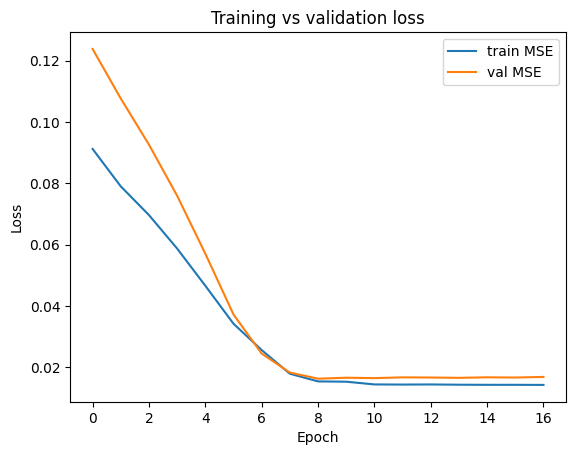

  best val_loss = 0.01632, epochs_used = 9
Config: {'u1': 128, 'u2': 64, 'dense': 64, 'drop': 0.5, 'lr': 0.001}
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - loss: 0.0733 - mae: 0.2030 - val_loss: 0.0519 - val_mae: 0.1862
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.0289 - mae: 0.1275 - val_loss: 0.0237 - val_mae: 0.1101
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.0246 - mae: 0.1123 - val_loss: 0.0208 - val_mae: 0.1006
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.0152 - mae: 0.0853 - val_loss: 0.0159 - val_mae: 0.0831
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.0179 - mae: 0.0948 - val_loss: 0.0173 - val_mae: 0.0876
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.0145 - mae: 0.0811 - val_loss: 0.0159 - val_mae: 0.0824
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.0156 - mae: 0.0848 - val_loss: 0.0165 - val_mae: 0.0843
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.0144 - mae: 0.08

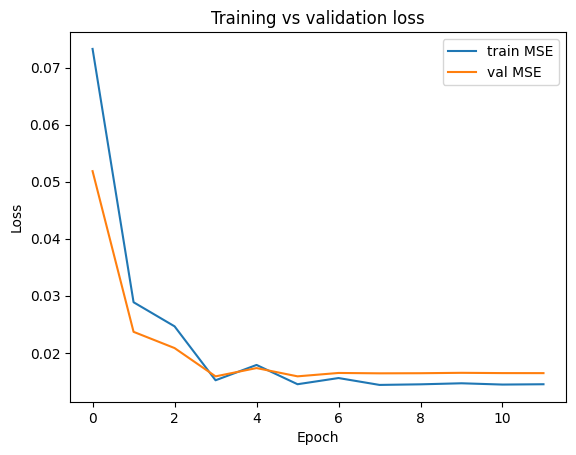

  best val_loss = 0.01587, epochs_used = 4
Config: {'u1': 128, 'u2': 64, 'dense': 64, 'drop': 0.3, 'lr': 0.0005}
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - loss: 0.0841 - mae: 0.2161 - val_loss: 0.0994 - val_mae: 0.2510
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 0.0482 - mae: 0.1727 - val_loss: 0.0464 - val_mae: 0.1747
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.0277 - mae: 0.1299 - val_loss: 0.0257 - val_mae: 0.1281
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.0218 - mae: 0.1137 - val_loss: 0.0200 - val_mae: 0.1009
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.0152 - mae: 0.0874 - val_loss: 0.0166 - val_mae: 0.0876
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 0.0164 - mae: 0.0891 - val_loss: 0.0168 - val_mae: 0.0861
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.0146 - mae: 0.0818 - val_loss: 0.0161 - val_mae: 0.0825
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.0151 - mae: 0.0

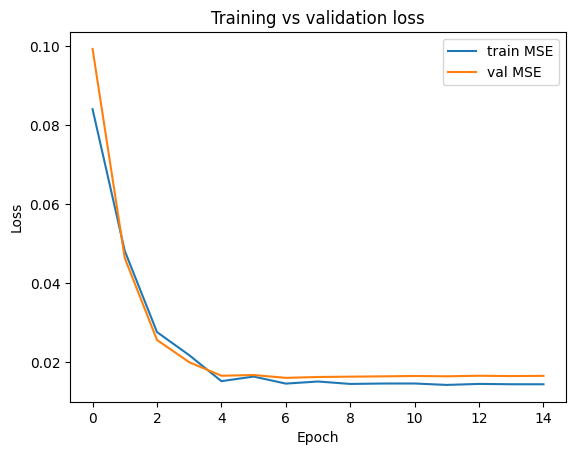

  best val_loss = 0.01607, epochs_used = 7
Best config: {'u1': 128, 'u2': 64, 'dense': 64, 'drop': 0.5, 'lr': 0.001} val_loss: 0.01587008871138096 best_epochs: 4


In [478]:
best_cfg, best_epochs = perform_validation(timesteps, n_features)


In [479]:
X_train_full = np.concatenate([X_train, X_val], axis=0)
y_train_full = np.concatenate([y_train_final, y_val], axis=0)

print(X_train_full.shape, y_train_full.shape)
# e.g. (297, 168, 1) and (297, 24)


(297, 168, 1) (297, 24)


In [480]:
final_model = build_model(
    units1=best_cfg['u1'],
    units2=best_cfg['u2'],
    dense_units=best_cfg['dense'],
    dropout_rate=best_cfg['drop'],
    lr=best_cfg['lr']
)

history_final = final_model.fit(
    X_train_full, y_train_full,
    epochs=best_epochs,   # from tuning
    batch_size=32,
    shuffle=False,
    verbose=1
)


Epoch 1/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 0.0642 - mae: 0.1949
Epoch 2/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 0.0288 - mae: 0.1290
Epoch 3/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 0.0225 - mae: 0.1118
Epoch 4/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - loss: 0.0151 - mae: 0.0847


In [481]:
y_pred_scaled = final_model.predict(X_test)   # shape (N_test, 24)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step


In [485]:
# y_test and y_pred_scaled are in [0,1] (scaled)
# we need 2D arrays for scaler.inverse_transform

y_test_flat_scaled = y_test.reshape(-1, 1)
y_pred_flat_scaled = y_pred_scaled.reshape(-1, 1)

y_test_flat = scaler.inverse_transform(y_test_flat_scaled).ravel()
y_pred_flat = scaler.inverse_transform(y_pred_flat_scaled).ravel()

# reshape back to (N_days, 24)
y_test_inv = y_test_flat.reshape(y_test.shape)
y_pred_inv = y_pred_flat.reshape(y_pred_scaled.shape)


In [487]:
y_test_flat = y_test_inv[0].ravel()
y_pred_flat = y_pred_inv[0].ravel()

In [488]:
rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
mae  = mean_absolute_error(y_test_flat, y_pred_flat)

print(f'Overall RMSE: {rmse:.2f}')
print(f'Overall MAE:  {mae:.2f}')


Overall RMSE: 76.35
Overall MAE:  50.88


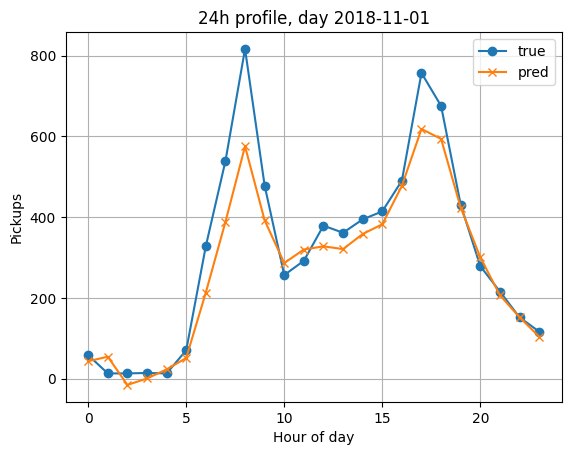

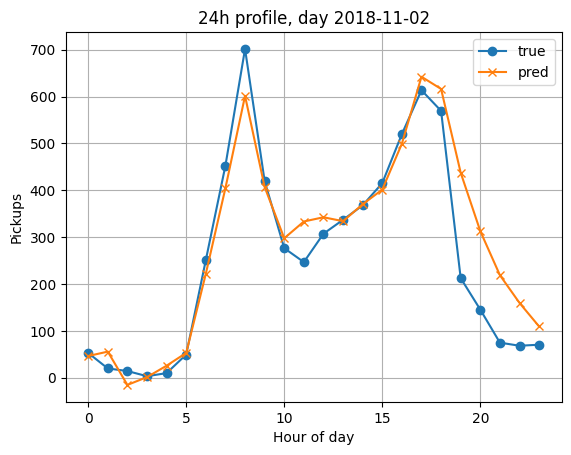

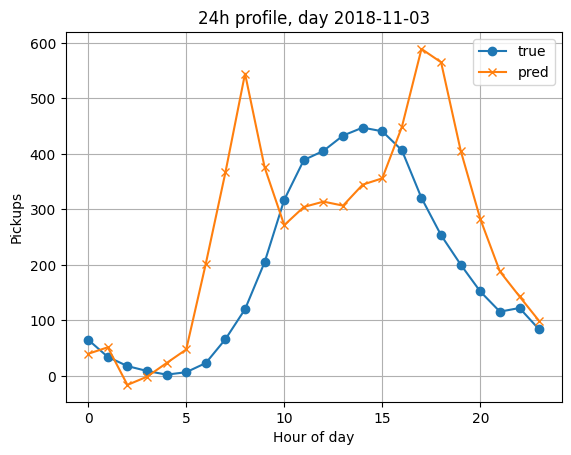

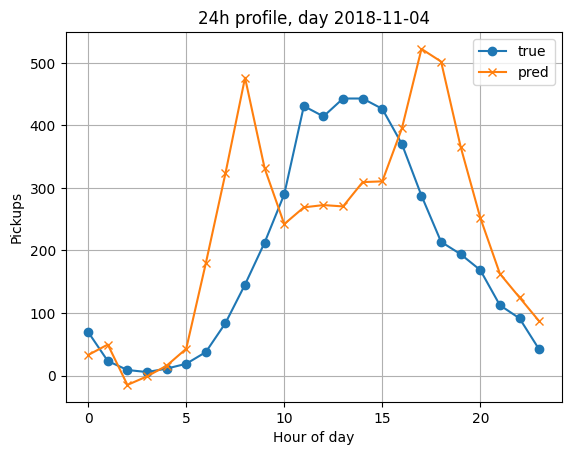

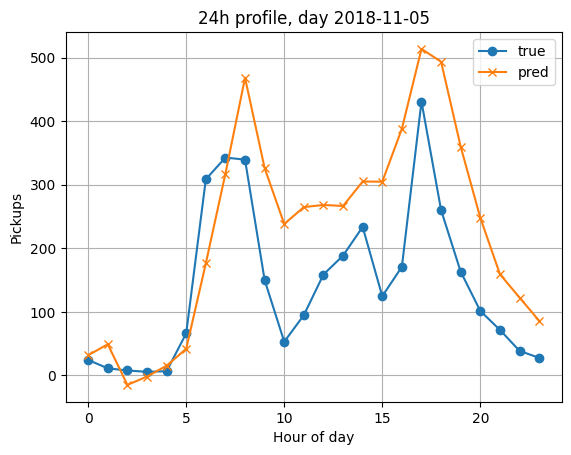

In [489]:
hours = np.arange(24)

n_plots =5   # first 5 test days, for example
for i in range(5):
    plt.figure()
    plt.plot(hours, y_test_inv[i], marker='o', label='true')
    plt.plot(hours, y_pred_inv[i], marker='x', label='pred')
    plt.xlabel('Hour of day')
    plt.ylabel('Pickups')
    plt.title(f'24h profile, day {test_dates[i]}')
    plt.legend()
    plt.grid(True)
    plt.show()


DROPOFFS

In [490]:
input_days = 7 
X_train_days, y_train, train_dates, X_test_days, y_test, test_dates = make_samples_with_dates(daily_values_dropoffs, dates_dropoffs, input_days=input_days)

In [491]:
val_size = 30  # days

X_train_days_final = X_train_days[:-val_size]
y_train_final       = y_train[:-val_size]

X_val_days          = X_train_days[-val_size:]
y_val               = y_train[-val_size:]

In [492]:
X_train = to_lstm_shape(X_train_days_final, input_days)
X_val   = to_lstm_shape(X_val_days,        input_days)
X_test  = to_lstm_shape(X_test_days,       input_days)

Config: {'u1': 64, 'u2': 32, 'dense': 32, 'drop': 0.1, 'lr': 0.001}
Epoch 1/50


c:\MSc DTU\Semester 1\00. Introduction to BA\Assignment\city-bike\CityBikesVenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - loss: 0.0692 - mae: 0.1937 - val_loss: 0.0800 - val_mae: 0.2232
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.0385 - mae: 0.1533 - val_loss: 0.0407 - val_mae: 0.1592
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.0289 - mae: 0.1313 - val_loss: 0.0286 - val_mae: 0.1312
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 0.0223 - mae: 0.1138 - val_loss: 0.0228 - val_mae: 0.1129
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - loss: 0.0145 - mae: 0.0868 - val_loss: 0.0150 - val_mae: 0.0871
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 0.0147 - mae: 0.0864 - val_loss: 0.0143 - val_mae: 0.0813
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 0.0122 - mae: 0.0757 - val_loss: 0.0129 - val_mae: 0.0759
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0123 - mae: 0.0756 - val_loss: 0.0130 - val_mae: 0.0751
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.0117 - mae: 0.0728 - va

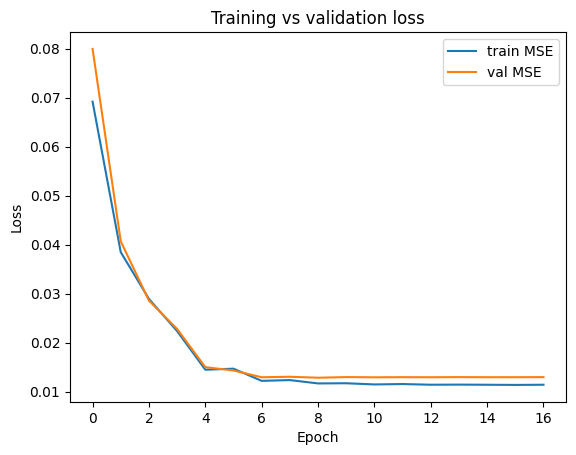

  best val_loss = 0.01282, epochs_used = 9
Config: {'u1': 128, 'u2': 64, 'dense': 64, 'drop': 0.5, 'lr': 0.001}
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 788ms/step - loss: 0.0477 - mae: 0.1649 - val_loss: 0.0385 - val_mae: 0.1644
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0278 - mae: 0.1285 - val_loss: 0.0228 - val_mae: 0.1100
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.0130 - mae: 0.0815 - val_loss: 0.0132 - val_mae: 0.0782
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.0160 - mae: 0.0891 - val_loss: 0.0153 - val_mae: 0.0847
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.0119 - mae: 0.0744 - val_loss: 0.0127 - val_mae: 0.0744
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.0131 - mae: 0.0785 - val_loss: 0.0131 - val_mae: 0.0759
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.0117 - mae: 0.0724 - val_loss: 0.0127 - val_mae: 0.0730
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.0119 - mae: 0.07

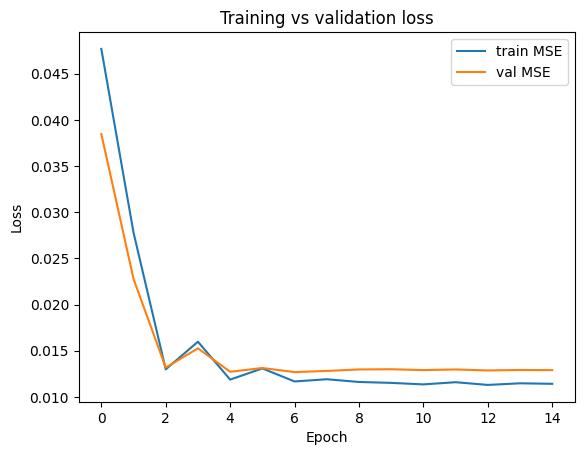

  best val_loss = 0.01269, epochs_used = 7
Config: {'u1': 128, 'u2': 64, 'dense': 64, 'drop': 0.3, 'lr': 0.0005}
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - loss: 0.0652 - mae: 0.1829 - val_loss: 0.0744 - val_mae: 0.2015
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 0.0359 - mae: 0.1374 - val_loss: 0.0413 - val_mae: 0.1569
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.0255 - mae: 0.1183 - val_loss: 0.0253 - val_mae: 0.1212
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - loss: 0.0167 - mae: 0.0951 - val_loss: 0.0165 - val_mae: 0.0932
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.0128 - mae: 0.0796 - val_loss: 0.0131 - val_mae: 0.0776
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.0126 - mae: 0.0764 - val_loss: 0.0132 - val_mae: 0.0764
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.0117 - mae: 0.0736 - val_loss: 0.0129 - val_mae: 0.0748
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.0119 - mae: 0.0

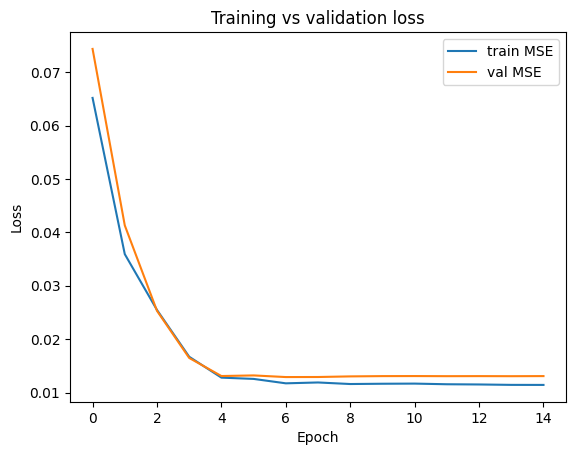

  best val_loss = 0.01290, epochs_used = 7
Best config: {'u1': 128, 'u2': 64, 'dense': 64, 'drop': 0.5, 'lr': 0.001} val_loss: 0.012691470794379711 best_epochs: 7


In [493]:
timesteps  = X_train.shape[1]   
n_features = X_train.shape[2]
best_cfg, best_epochs = perform_validation(timesteps, n_features)

In [494]:
X_train_full = np.concatenate([X_train, X_val], axis=0)
y_train_full = np.concatenate([y_train_final, y_val], axis=0)

print(X_train_full.shape, y_train_full.shape)
# e.g. (297, 168, 1) and (297, 24)


(297, 168, 1) (297, 24)


In [495]:
final_model = build_model(
    units1=best_cfg['u1'],
    units2=best_cfg['u2'],
    dense_units=best_cfg['dense'],
    dropout_rate=best_cfg['drop'],
    lr=best_cfg['lr']
)

history_final = final_model.fit(
    X_train_full, y_train_full,
    epochs=best_epochs,   # from tuning
    batch_size=32,
    shuffle=False,
    verbose=1
)


Epoch 1/7
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - loss: 0.0554 - mae: 0.1713
Epoch 2/7
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.0260 - mae: 0.1172
Epoch 3/7
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.0155 - mae: 0.0888
Epoch 4/7
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 0.0125 - mae: 0.0768
Epoch 5/7
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.0135 - mae: 0.0787
Epoch 6/7
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 0.0121 - mae: 0.0737
Epoch 7/7
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.0121 - mae: 0.0733


In [499]:
y_pred_scaled = final_model.predict(X_test)   # shape (N_test, 24)

# y_test and y_pred_scaled are in [0,1] (scaled)
# we need 2D arrays for scaler.inverse_transform

y_test_flat_scaled = y_test.reshape(-1, 1)
y_pred_flat_scaled = y_pred_scaled.reshape(-1, 1)

y_test_flat = scaler.inverse_transform(y_test_flat_scaled).ravel()
y_pred_flat = scaler.inverse_transform(y_pred_flat_scaled).ravel()

# reshape back to (N_days, 24)
y_test_inv = y_test_flat.reshape(y_test.shape)
y_pred_inv = y_pred_flat.reshape(y_pred_scaled.shape)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


In [497]:
y_test_flat = y_test_inv[0].ravel()
y_pred_flat = y_pred_inv[0].ravel()

In [500]:
rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
mae  = mean_absolute_error(y_test_flat, y_pred_flat)

print(f'Overall RMSE: {rmse:.2f}')
print(f'Overall MAE:  {mae:.2f}')


Overall RMSE: 93.53
Overall MAE:  61.73


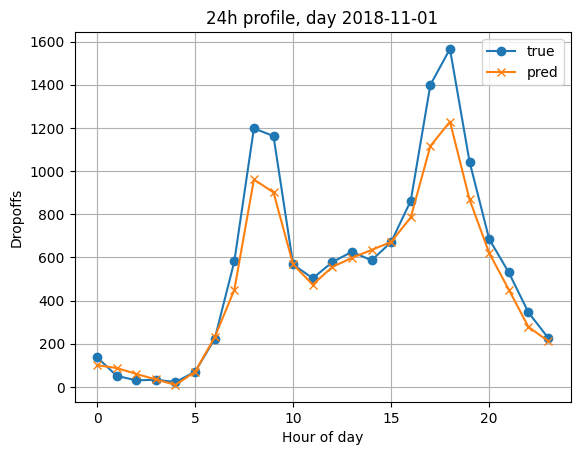

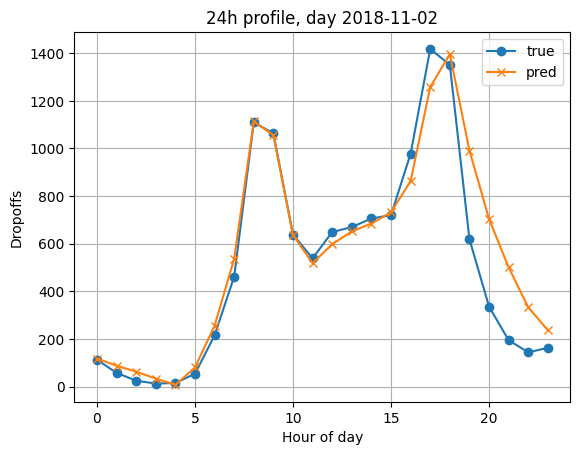

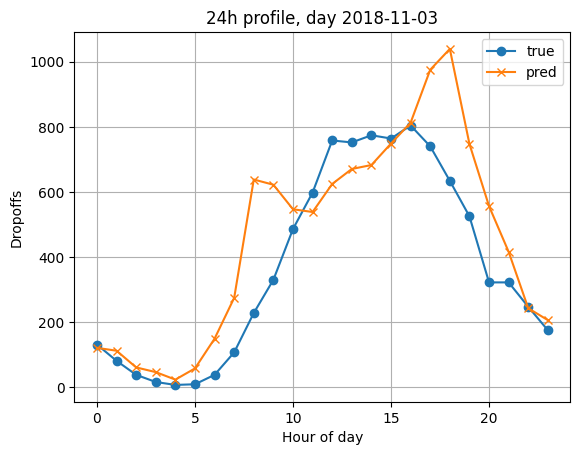

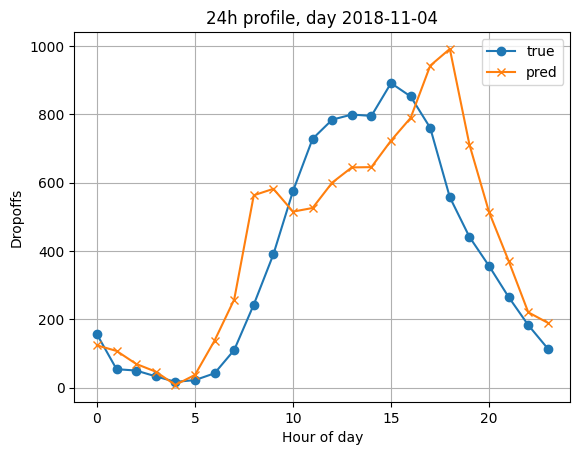

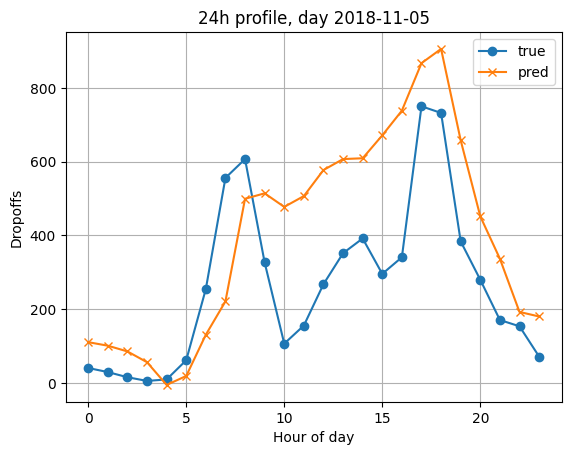

In [458]:
hours = np.arange(24)

n_plots =5   # first 5 test days, for example
for i in range(5):
    plt.figure()
    plt.plot(hours, y_test_inv[i], marker='o', label='true')
    plt.plot(hours, y_pred_inv[i], marker='x', label='pred')
    plt.xlabel('Hour of day')
    plt.ylabel('Dropoffs')
    plt.title(f'24h profile, day {test_dates[i]}')
    plt.legend()
    plt.grid(True)
    plt.show()
